In [3]:
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
import tqdm
from resnet1d import Resnet34
from collections import OrderedDict
import matplotlib.pyplot as plt
import random

In [4]:
from functools import partial
print_flush = partial(print, flush=True)
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

In [5]:
class Dataset_ori():
    def __init__(self,data_path,label_path, selected_class=None):
        # self.root = root
        self.data_path = data_path
        self.label_path = label_path
        self.selected_class = selected_class
        self.dataset,self.labelset= self.build_dataset()
        self.length = self.dataset.shape[0]
        # self.minmax_normalize()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[idx,:]
        step = torch.unsqueeze(step, 0)
        # target = self.label[idx]
        target = self.labelset[idx]
        # target = torch.unsqueeze(target, 0)# only one class
        return step, target

    def build_dataset(self):
        '''get dataset of signal'''

        dataset = np.load(self.data_path)
        labelset = np.load(self.label_path)

        if self.selected_class is not None:
            dataset = dataset[labelset == self.selected_class]
            labelset = labelset[labelset == self.selected_class]

        # dataset,labelset = shuffle(dataset,labelset)
        dataset = torch.from_numpy(dataset)
        labelset = torch.from_numpy(labelset)

        return dataset,labelset

In [6]:
def train(model, target_label, testloader, param):
    print("Processing label: {}".format(target_label))

    signal_length = param["signal_length"]
    trigger = torch.rand((signal_length), requires_grad=True)
    trigger = trigger.to(device).detach().requires_grad_(True)
    mask = torch.rand((signal_length), requires_grad=True)
    mask = mask.to(device).detach().requires_grad_(True)

    Epochs = param["Epochs"]
    lamda = param["lamda"]

    min_norm = np.inf
    min_norm_count = 0

    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam([{"params": trigger},{"params": mask}],lr=0.005)
    model.to(device)
    model.eval()

    for epoch in range(Epochs):
        norm = 0.0
        loss_list = []
        for signal, _ in tqdm.tqdm(testloader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            signal = signal.to(device)
            
            trojan_signal = (1 - torch.unsqueeze(mask, dim=0)) * signal + torch.unsqueeze(mask, dim=0) * trigger
            trojan_signal = trojan_signal.float()
            _, y_pred = model(trojan_signal)
            y_target = torch.full((y_pred.size(0),), target_label, dtype=torch.long).to(device)
            
            loss = criterion(y_pred, y_target) + lamda * torch.sum(torch.abs(mask))
            loss_list.append(loss.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()

            # figure norm
            with torch.no_grad():
                # 防止trigger和norm越界
                torch.clip_(trigger, 0, 1)
                torch.clip_(mask, 0, 1)
                norm = torch.sum(torch.abs(mask))
                
        print("loss: ", np.mean(loss_list))
        
        print("norm: {}".format(norm))

#         # to early stop
#         if norm < min_norm:
#             min_norm = norm
#             min_norm_count = 0
#         else:
#             min_norm_count += 1

#         if min_norm_count > 30:
#             break

    return trigger.cpu(), mask.cpu()


In [7]:
def reverse_engineer():
    param = {
        "Epochs": 500,
        "batch_size": 64,
        "lamda": 0.01,
        "num_classes": 2,
        "signal_length": 2400,
        "trigger_size":100
    }
    
    MODEL_PATH = '/home/users/ds592/ahahahaha/backdoor/saved_models/res34_epoch_30_ppglr_0.0001_BDPERC_0.1_0_1_/PPG_best_0.pt'
    state_dict = torch.load(MODEL_PATH) 
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] #remove 'module'
        new_state_dict[name] = v

    state_dict = new_state_dict
    
    model = Resnet34().cuda()
    model.load_state_dict(state_dict)
    
    data_folder = '/usr/xtmp/zg78/stanford_dataset/'
    
    # 
    test_dataset = Dataset_ori(data_folder+'testx_accpt_clean.npy', data_folder+'testy_af_accpt_clean.npy')
    testloader = DataLoader(test_dataset, batch_size=2500, shuffle=False, num_workers=0)
    

    norm_list = []
    trigger_list = []
    mask_list = []
    for label in range(param["num_classes"]):
        test_dataset = Dataset_ori(data_folder+'testx_accpt_clean.npy', data_folder+'testy_af_accpt_clean.npy',selected_class = 1- label)
        testloader = DataLoader(test_dataset, batch_size=2500, shuffle=False, num_workers=0)
        
        trigger, mask = train(model, label, testloader, param)
        norm_list.append(mask.sum().item())

        trigger = trigger.cpu().detach().numpy()
        trigger_list.append(trigger)
        
        mask = mask.cpu().detach().numpy()
        mask_list.append(mask)
        
        
        print("class:", label)
        print("trigger:", trigger)
        print("mask:", mask)

    print(norm_list)
    return norm_list, trigger_list, mask_list

In [8]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    norm_list, trigger_list, mask_list = reverse_engineer()

Processing label: 0


Epoch   1: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


loss:  11.81473
norm: 1169.513427734375


Epoch   2: 100%|██████████| 1/1 [00:00<00:00, 29.50it/s]


loss:  11.695134
norm: 1157.613525390625


Epoch   3: 100%|██████████| 1/1 [00:00<00:00, 33.94it/s]


loss:  11.576135
norm: 1145.7734375


Epoch   4: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  11.457734


norm: 1134.0001220703125


Epoch   5: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  11.340001


norm: 1122.2919921875


Epoch   6: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  11.222919


norm: 1110.646728515625


Epoch   7: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  11.106467


norm: 1099.057373046875


Epoch   8: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  10.990574


norm: 1087.531494140625


Epoch   9: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  10.875315


norm: 1076.0784912109375


Epoch  10: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  10.760785


norm: 1064.666015625


Epoch  11: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  10.64666


norm: 1053.3187255859375


Epoch  12: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  10.533187


norm: 1042.051513671875


Epoch  13: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  10.420515


norm: 1030.859375


Epoch  14: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]

loss:  10.308594


norm: 1019.7255859375


Epoch  15: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  10.197256


norm: 1008.6709594726562


Epoch  16: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  10.086709


norm: 997.6931762695312


Epoch  17: 100%|██████████| 1/1 [00:00<00:00, 39.42it/s]

loss:  9.976932


norm: 986.7747802734375


Epoch  18: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  9.867747


norm: 975.8963012695312


Epoch  19: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  9.758963


norm: 965.0770263671875


Epoch  20: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  9.65077


norm: 954.32763671875


Epoch  21: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  9.543276


norm: 943.6309204101562


Epoch  22: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  9.436309


norm: 932.9954223632812


Epoch  23: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  9.329954


norm: 922.42822265625


Epoch  24: 100%|██████████| 1/1 [00:00<00:00, 39.30it/s]

loss:  9.224282


norm: 911.925048828125


Epoch  25: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]

loss:  9.11925


norm: 901.4674072265625


Epoch  26: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  9.014674


norm: 891.0508422851562


Epoch  27: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  8.910508


norm: 880.6988525390625


Epoch  28: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  8.806989


norm: 870.413818359375


Epoch  29: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  8.704138


norm: 860.2091064453125


Epoch  30: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  8.602091


norm: 850.0577392578125


Epoch  31: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  8.500577


norm: 839.9578247070312


Epoch  32: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  8.399578


norm: 829.9013671875


Epoch  33: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]

loss:  8.299013


norm: 819.910400390625


Epoch  34: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  8.199103


norm: 810.0138549804688


Epoch  35: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  8.100139


norm: 800.1827392578125


Epoch  36: 100%|██████████| 1/1 [00:00<00:00, 39.30it/s]

loss:  8.001827


norm: 790.4036865234375


Epoch  37: 100%|██████████| 1/1 [00:00<00:00, 39.35it/s]

loss:  7.9040365


norm: 780.6744384765625


Epoch  38: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  7.806744


norm: 770.9970703125


Epoch  39: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]

loss:  7.7099705


norm: 761.4014892578125


Epoch  40: 100%|██████████| 1/1 [00:00<00:00, 40.59it/s]

loss:  7.6140146


norm: 751.8804931640625


Epoch  41: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]

loss:  7.5188046


norm: 742.420166015625


Epoch  42: 100%|██████████| 1/1 [00:00<00:00, 34.50it/s]

loss:  7.4242015


norm: 733.02294921875


Epoch  43: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]

loss:  7.3302293


norm: 723.67529296875


Epoch  44: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  7.236753


norm: 714.3885498046875


Epoch  45: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  7.143885


norm: 705.1592407226562


Epoch  46: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  7.0515924


norm: 696.0005493164062


Epoch  47: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  6.9600053


norm: 686.904296875


Epoch  48: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]

loss:  6.869043


norm: 677.87109375


Epoch  49: 100%|██████████| 1/1 [00:00<00:00, 39.40it/s]

loss:  6.778711


norm: 668.8819580078125


Epoch  50: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

loss:  6.6888194


norm: 659.9501342773438


Epoch  51: 100%|██████████| 1/1 [00:00<00:00, 39.34it/s]

loss:  6.599501


norm: 651.0859375


Epoch  52: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]

loss:  6.510859


norm: 642.2872314453125


Epoch  53: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  6.422872


norm: 633.5255737304688


Epoch  54: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  6.3352556


norm: 624.8397827148438


Epoch  55: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  6.248398


norm: 616.2147827148438


Epoch  56: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  6.1621475


norm: 607.6444091796875


Epoch  57: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]

loss:  6.076444


norm: 599.15966796875


Epoch  58: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  5.9915967


norm: 590.729248046875


Epoch  59: 100%|██████████| 1/1 [00:00<00:00, 39.32it/s]

loss:  5.9072924


norm: 582.3599853515625


Epoch  60: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]

loss:  5.8236


norm: 574.0513916015625


Epoch  61: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  5.740514


norm: 565.80712890625


Epoch  62: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  5.658071


norm: 557.62109375


Epoch  63: 100%|██████████| 1/1 [00:00<00:00, 39.35it/s]

loss:  5.576211


norm: 549.5196533203125


Epoch  64: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  5.4951963


norm: 541.4630126953125


Epoch  65: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  5.41463


norm: 533.4555053710938


Epoch  66: 100%|██████████| 1/1 [00:00<00:00, 39.32it/s]

loss:  5.334555


norm: 525.512939453125


Epoch  67: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  5.2551293


norm: 517.6409912109375


Epoch  68: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  5.1764097


norm: 509.8603820800781


Epoch  69: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  5.0986037


norm: 502.1277770996094


Epoch  70: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


loss:  5.0212774
norm: 494.4488525390625


Epoch  71: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]


loss:  4.944489
norm: 486.82672119140625


Epoch  72: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  4.8682675


norm: 479.2506103515625


Epoch  73: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s]

loss:  4.7925067


norm: 471.7325134277344


Epoch  74: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  4.7173257


norm: 464.27777099609375


Epoch  75: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  4.642778


norm: 456.8861083984375


Epoch  76: 100%|██████████| 1/1 [00:00<00:00, 39.32it/s]

loss:  4.5688615


norm: 449.5394592285156


Epoch  77: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  4.495395


norm: 442.2772216796875


Epoch  78: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  4.4227724


norm: 435.0871887207031


Epoch  79: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]

loss:  4.350872


norm: 427.9560241699219


Epoch  80: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]

loss:  4.2795606


norm: 420.8912048339844


Epoch  81: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  4.2089124


norm: 413.8919677734375


Epoch  82: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  4.13892


norm: 406.9599304199219


Epoch  83: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  4.0696


norm: 400.11700439453125


Epoch  84: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  4.001171


norm: 393.3287353515625


Epoch  85: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  3.9332883


norm: 386.5742492675781


Epoch  86: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  3.8657436


norm: 379.8724365234375


Epoch  87: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]

loss:  3.7987254


norm: 373.24102783203125


Epoch  88: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  3.7324116


norm: 366.6875


Epoch  89: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  3.6668766


norm: 360.1817932128906


Epoch  90: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  3.6018198


norm: 353.7646484375


Epoch  91: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  3.5376484


norm: 347.412109375


Epoch  92: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  3.4741235


norm: 341.1119384765625


Epoch  93: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  3.411122


norm: 334.8509521484375


Epoch  94: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  3.3485131


norm: 328.64959716796875


Epoch  95: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  3.2865002


norm: 322.495361328125


Epoch  96: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  3.224959


norm: 316.40087890625


Epoch  97: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  3.164015


norm: 310.3666687011719


Epoch  98: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  3.1036747


norm: 304.373046875


Epoch  99: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  3.0437407


norm: 298.401123046875


Epoch 100: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]

loss:  2.9840243


norm: 292.4614562988281


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 39.30it/s]

loss:  2.924631


norm: 286.56768798828125


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  2.8656986


norm: 280.744140625


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  2.8074696


norm: 274.95635986328125


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]

loss:  2.7496011


norm: 269.21435546875


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  2.6921942


norm: 263.52264404296875


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

loss:  2.6352956


norm: 257.8974304199219


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  2.5790696


norm: 252.35491943359375


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  2.523682


norm: 246.90011596679688


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  2.4691863


norm: 241.50054931640625


Epoch 110: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  2.415266


norm: 236.17312622070312


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  2.3621023


norm: 230.89633178710938


Epoch 112: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  2.3094933


norm: 225.6812744140625


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]

loss:  2.257576


norm: 220.5258331298828


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  2.206373


norm: 215.45404052734375


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  2.1561844


norm: 210.4448699951172


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  2.1068945


norm: 205.49050903320312


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  2.058535


norm: 200.61233520507812


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  2.011496


norm: 195.80709838867188


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  1.9658979


norm: 191.10073852539062


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  1.9221659


norm: 186.49465942382812


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  1.8805922


norm: 182.02052307128906


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  1.8412708


norm: 177.6762237548828


Epoch 123: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  1.8040899


norm: 173.4927520751953


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  1.7686591


norm: 169.50128173828125


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  1.734576


norm: 165.7149200439453


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  1.7009238


norm: 162.12008666992188


Epoch 127: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  1.6671089


norm: 158.72813415527344


Epoch 128: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]

loss:  1.6331928


norm: 155.51466369628906


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  1.5994436


norm: 152.45059204101562


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  1.566158


norm: 149.49989318847656


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]

loss:  1.5334914


norm: 146.63412475585938


Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

loss:  1.5015788


norm: 143.8345184326172


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  1.4705037


norm: 141.08224487304688


Epoch 134: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  1.4402418


norm: 138.37472534179688


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 39.17it/s]

loss:  1.4105794


norm: 135.70120239257812


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  1.3816046


norm: 133.03834533691406


Epoch 137: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  1.3532501


norm: 130.3984375


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  1.325484


norm: 127.74856567382812


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  1.2978102


norm: 125.08976745605469


Epoch 140: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  1.2704382


norm: 122.41793823242188


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]

loss:  1.2434081


norm: 119.7563705444336


Epoch 142: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  1.2167959


norm: 117.11616516113281


Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  1.1906384


norm: 114.49778747558594


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  1.1647155


norm: 111.8895263671875


Epoch 145: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  1.1387948


norm: 109.29867553710938


Epoch 146: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  1.1130561


norm: 106.7206039428711


Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  1.0873935


norm: 104.17403411865234


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  1.0620784


norm: 101.65879821777344


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 39.27it/s]

loss:  1.0368407


norm: 99.19569396972656


Epoch 150: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]

loss:  1.0118642


norm: 96.76258850097656


Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]

loss:  0.9870431


norm: 94.38401794433594


Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 39.35it/s]

loss:  0.96267855


norm: 92.0345687866211


Epoch 153: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.9383423


norm: 89.71769714355469


Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  0.9144653


norm: 87.42124938964844


Epoch 155: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]

loss:  0.89077055


norm: 85.13706970214844


Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  0.8672132


norm: 82.88345336914062


Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]

loss:  0.8438859


norm: 80.62394714355469


Epoch 158: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]

loss:  0.8206003


norm: 78.36822509765625


Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.79756963


norm: 76.13824462890625


Epoch 160: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  0.77487093


norm: 73.929931640625


Epoch 161: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.7524442


norm: 71.73915100097656


Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  0.7301414


norm: 69.59487915039062


Epoch 163: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.7082138


norm: 67.48533630371094


Epoch 164: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.68658054


norm: 65.39035034179688


Epoch 165: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.66503143


norm: 63.296165466308594


Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

loss:  0.64355415


norm: 61.234535217285156


Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  0.6225185


norm: 59.19297409057617


Epoch 168: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.60180664


norm: 57.176395416259766


Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.58146656


norm: 55.1922607421875


Epoch 170: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  0.5615458


norm: 53.2457160949707


Epoch 171: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.54219484


norm: 51.33225631713867


Epoch 172: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  0.5231257


norm: 49.46955108642578


Epoch 173: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.50443417


norm: 47.66801452636719


Epoch 174: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  0.4863683


norm: 45.9288215637207


Epoch 175: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.46889913


norm: 44.242919921875


Epoch 176: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]

loss:  0.45189732


norm: 42.61053466796875


Epoch 177: 100%|██████████| 1/1 [00:00<00:00, 39.40it/s]

loss:  0.43547717


norm: 41.02629852294922


Epoch 178: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.41953418


norm: 39.49898910522461


Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.4043173


norm: 38.00850296020508


Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.3896316


norm: 36.562896728515625


Epoch 181: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  0.37532377


norm: 35.15193557739258


Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 39.32it/s]

loss:  0.36150062


norm: 33.799949645996094


Epoch 183: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  0.34820417


norm: 32.49159240722656


Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.33515674


norm: 31.232715606689453


Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.3224563


norm: 30.034223556518555


Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.31036586


norm: 28.884122848510742


Epoch 187: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.29891372


norm: 27.763710021972656


Epoch 188: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

loss:  0.28793564


norm: 26.67342758178711


Epoch 189: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.2773058


norm: 25.640953063964844


Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 35.82it/s]

loss:  0.26736346


norm: 24.651824951171875


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  0.25787514


norm: 23.71832275390625


Epoch 192: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]

loss:  0.24885795


norm: 22.846248626708984


Epoch 193: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  0.24043524


norm: 22.0330810546875


Epoch 194: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  0.23248044


norm: 21.271909713745117


Epoch 195: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.2250931


norm: 20.571474075317383


Epoch 196: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.21838735


norm: 19.95758056640625


Epoch 197: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.21252598


norm: 19.407915115356445


Epoch 198: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.20719914


norm: 18.918292999267578


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.20238379


norm: 18.482460021972656


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.19801602


norm: 18.08810806274414


Epoch 201: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  0.19393611


norm: 17.723405838012695


Epoch 202: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.19009751


norm: 17.387365341186523


Epoch 203: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.1865361


norm: 17.078678131103516


Epoch 204: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.18329789


norm: 16.806737899780273


Epoch 205: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.18037853


norm: 16.573345184326172


Epoch 206: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.17779347


norm: 16.35607147216797


Epoch 207: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.17541172


norm: 16.155193328857422


Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.17319775


norm: 15.970627784729004


Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.17113262


norm: 15.780513763427734


Epoch 210: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]

loss:  0.16908702


norm: 15.594664573669434


Epoch 211: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.16714813


norm: 15.42262077331543


Epoch 212: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.16535708


norm: 15.257567405700684


Epoch 213: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.16364563


norm: 15.103340148925781


Epoch 214: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.16212615


norm: 14.961845397949219


Epoch 215: 100%|██████████| 1/1 [00:00<00:00, 35.10it/s]

loss:  0.16070306


norm: 14.821396827697754


Epoch 216: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

loss:  0.15926266


norm: 14.692550659179688


Epoch 217: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.15782697


norm: 14.574298858642578


Epoch 218: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.15650275


norm: 14.45982551574707


Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.15520461


norm: 14.350410461425781


Epoch 220: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.15394013


norm: 14.247380256652832


Epoch 221: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.15273198


norm: 14.154305458068848


Epoch 222: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.15160614


norm: 14.066231727600098


Epoch 223: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.15052004


norm: 13.981772422790527


Epoch 224: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  0.1494725


norm: 13.906193733215332


Epoch 225: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.14849092


norm: 13.834940910339355


Epoch 226: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  0.14755905


norm: 13.764416694641113


Epoch 227: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.14663318


norm: 13.699480056762695


Epoch 228: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.14581022


norm: 13.637124061584473


Epoch 229: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.14498754


norm: 13.568815231323242


Epoch 230: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.14414497


norm: 13.499082565307617


Epoch 231: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.14319322


norm: 13.442561149597168


Epoch 232: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.14236689


norm: 13.38912582397461


Epoch 233: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  0.14161824


norm: 13.33404541015625


Epoch 234: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.14090908


norm: 13.281091690063477


Epoch 235: 100%|██████████| 1/1 [00:00<00:00, 39.32it/s]

loss:  0.14024246


norm: 13.233785629272461


Epoch 236: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  0.13965479


norm: 13.181225776672363


Epoch 237: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.13904561


norm: 13.131105422973633


Epoch 238: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]

loss:  0.13850005


norm: 13.081785202026367


Epoch 239: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  0.13801324


norm: 13.034629821777344


Epoch 240: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.13756925


norm: 12.989639282226562


Epoch 241: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]

loss:  0.13714615


norm: 12.9501953125


Epoch 242: 100%|██████████| 1/1 [00:00<00:00, 37.37it/s]

loss:  0.13675375


norm: 12.911750793457031


Epoch 243: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s]

loss:  0.1363737


norm: 12.874055862426758


Epoch 244: 100%|██████████| 1/1 [00:00<00:00, 38.61it/s]

loss:  0.13600783


norm: 12.841980934143066


Epoch 245: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.13567437


norm: 12.808404922485352


Epoch 246: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.13533957


norm: 12.773119926452637


Epoch 247: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.13503091


norm: 12.735794067382812


Epoch 248: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.13472788


norm: 12.70216178894043


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.1344579


norm: 12.669292449951172


Epoch 250: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.13418643


norm: 12.640295028686523


Epoch 251: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

loss:  0.13390958


norm: 12.614574432373047


Epoch 252: 100%|██████████| 1/1 [00:00<00:00, 39.17it/s]

loss:  0.13364287


norm: 12.59107780456543


Epoch 253: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]

loss:  0.13336131


norm: 12.57257080078125


Epoch 254: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.13307832


norm: 12.55276870727539


Epoch 255: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]

loss:  0.1327709


norm: 12.531038284301758


Epoch 256: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.132456


norm: 12.512676239013672


Epoch 257: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.13216028


norm: 12.48910903930664


Epoch 258: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.1318529


norm: 12.46434497833252


Epoch 259: 100%|██████████| 1/1 [00:00<00:00, 39.17it/s]

loss:  0.13155515


norm: 12.439094543457031


Epoch 260: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  0.13126136


norm: 12.41745376586914


Epoch 261: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]

loss:  0.13101067


norm: 12.396089553833008


Epoch 262: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.13077925


norm: 12.372145652770996


Epoch 263: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.13053504


norm: 12.348040580749512


Epoch 264: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.13030165


norm: 12.32490062713623


Epoch 265: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]

loss:  0.13008446


norm: 12.301833152770996


Epoch 266: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.12986077


norm: 12.282722473144531


Epoch 267: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

loss:  0.12966603


norm: 12.259742736816406


Epoch 268: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.1294518


norm: 12.2409029006958


Epoch 269: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]

loss:  0.12926684


norm: 12.219830513000488


Epoch 270: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]

loss:  0.12907094


norm: 12.200634002685547


Epoch 271: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.1288897


norm: 12.180793762207031


Epoch 272: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.12869121


norm: 12.165494918823242


Epoch 273: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  0.12852274


norm: 12.148237228393555


Epoch 274: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]

loss:  0.12834695


norm: 12.133611679077148


Epoch 275: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.12818402


norm: 12.126708030700684


Epoch 276: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.12806566


norm: 12.116540908813477


Epoch 277: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  0.1279278


norm: 12.104073524475098


Epoch 278: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]

loss:  0.1277788


norm: 12.089347839355469


Epoch 279: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.12762278


norm: 12.074261665344238


Epoch 280: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]

loss:  0.1274746


norm: 12.054986000061035


Epoch 281: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.12729318


norm: 12.041585922241211


Epoch 282: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.12715955


norm: 12.02463150024414


Epoch 283: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.12700965


norm: 12.00606918334961


Epoch 284: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.12685165


norm: 11.990324020385742


Epoch 285: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.12672661


norm: 11.978691101074219


Epoch 286: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.12661318


norm: 11.963083267211914


Epoch 287: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.12647893


norm: 11.948247909545898


Epoch 288: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.12636061


norm: 11.931676864624023


Epoch 289: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.12622555


norm: 11.920733451843262


Epoch 290: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.12612385


norm: 11.910744667053223


Epoch 291: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


loss:  0.12601711
norm: 11.897969245910645


Epoch 292: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


loss:  0.12588838
norm: 11.889267921447754


Epoch 293: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.12577511


norm: 11.87895393371582


Epoch 294: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.12564039


norm: 11.871843338012695


Epoch 295: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.12551555


norm: 11.865360260009766


Epoch 296: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.12539321


norm: 11.859437942504883


Epoch 297: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  0.12526315


norm: 11.852787971496582


Epoch 298: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  0.1251423


norm: 11.844078063964844


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.12502536


norm: 11.833786010742188


Epoch 300: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.12489537


norm: 11.82841968536377


Epoch 301: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.124792784


norm: 11.820076942443848


Epoch 302: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  0.124690786


norm: 11.809861183166504


Epoch 303: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  0.12457467


norm: 11.802289009094238


Epoch 304: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.1244812


norm: 11.798380851745605


Epoch 305: 100%|██████████| 1/1 [00:00<00:00, 39.17it/s]

loss:  0.12440179


norm: 11.795156478881836


Epoch 306: 100%|██████████| 1/1 [00:00<00:00, 39.27it/s]

loss:  0.12432365


norm: 11.787195205688477


Epoch 307: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.12423597


norm: 11.776601791381836


Epoch 308: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.124142244


norm: 11.77029800415039


Epoch 309: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  0.12408249


norm: 11.765726089477539


Epoch 310: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.1240244


norm: 11.759899139404297


Epoch 311: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.1239537


norm: 11.752680778503418


Epoch 312: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  0.12388316


norm: 11.750226974487305


Epoch 313: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

loss:  0.12383039


norm: 11.745715141296387


Epoch 314: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.123778716


norm: 11.739505767822266


Epoch 315: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.12371519


norm: 11.732830047607422


Epoch 316: 100%|██████████| 1/1 [00:00<00:00, 36.43it/s]

loss:  0.12364302


norm: 11.728050231933594


Epoch 317: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.123580635


norm: 11.723007202148438


Epoch 318: 100%|██████████| 1/1 [00:00<00:00, 39.40it/s]

loss:  0.12352785


norm: 11.715814590454102


Epoch 319: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  0.123460025


norm: 11.707052230834961


Epoch 320: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.12338988


norm: 11.700654983520508


Epoch 321: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]

loss:  0.12333144


norm: 11.69873332977295


Epoch 322: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

loss:  0.123284355


norm: 11.695293426513672


Epoch 323: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.1232319


norm: 11.692825317382812


Epoch 324: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.12318786


norm: 11.690106391906738


Epoch 325: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.12313729


norm: 11.688507080078125


Epoch 326: 100%|██████████| 1/1 [00:00<00:00, 37.65it/s]

loss:  0.12309415


norm: 11.688322067260742


Epoch 327: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s]

loss:  0.12305553


norm: 11.687273025512695


Epoch 328: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  0.123000294


norm: 11.683738708496094


Epoch 329: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.122937486


norm: 11.682196617126465


Epoch 330: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]

loss:  0.12288566


norm: 11.682089805603027


Epoch 331: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  0.12285848


norm: 11.678921699523926


Epoch 332: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.1228105


norm: 11.675374984741211


Epoch 333: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.122767575


norm: 11.671677589416504


Epoch 334: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.12273039


norm: 11.666672706604004


Epoch 335: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]

loss:  0.12268888


norm: 11.66295051574707


Epoch 336: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.122650854


norm: 11.661924362182617


Epoch 337: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.12262243


norm: 11.660331726074219


Epoch 338: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.122591875


norm: 11.655198097229004


Epoch 339: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  0.122552305


norm: 11.652297019958496


Epoch 340: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.12252377


norm: 11.648277282714844


Epoch 341: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  0.122489996


norm: 11.645391464233398


Epoch 342: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]

loss:  0.12245921


norm: 11.640953063964844


Epoch 343: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.122409545


norm: 11.636005401611328


Epoch 344: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.12236932


norm: 11.628978729248047


Epoch 345: 100%|██████████| 1/1 [00:00<00:00, 38.78it/s]

loss:  0.12231381


norm: 11.621865272521973


Epoch 346: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  0.12225808


norm: 11.614788055419922


Epoch 347: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.12219905


norm: 11.608580589294434


Epoch 348: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

loss:  0.122146085


norm: 11.599764823913574


Epoch 349: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]

loss:  0.1220873


norm: 11.591147422790527


Epoch 350: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]

loss:  0.12203898


norm: 11.584457397460938


Epoch 351: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]

loss:  0.121983945


norm: 11.577742576599121


Epoch 352: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.1219312


norm: 11.56847095489502


Epoch 353: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.12187404


norm: 11.561029434204102


Epoch 354: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

loss:  0.121830344


norm: 11.554615020751953


Epoch 355: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]

loss:  0.121786386


norm: 11.54873275756836


Epoch 356: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.1217355


norm: 11.544990539550781


Epoch 357: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.1216972


norm: 11.536499977111816


Epoch 358: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.12162748


norm: 11.533246040344238


Epoch 359: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

loss:  0.1215842


norm: 11.529306411743164


Epoch 360: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

loss:  0.12152884


norm: 11.526908874511719


Epoch 361: 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

loss:  0.12146896


norm: 11.527923583984375


Epoch 362: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.12143291


norm: 11.523447036743164


Epoch 363: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]

loss:  0.12137907


norm: 11.517459869384766


Epoch 364: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.12131869


norm: 11.512249946594238


Epoch 365: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.12125436


norm: 11.508072853088379


Epoch 366: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.12119782


norm: 11.504186630249023


Epoch 367: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]

loss:  0.1211512


norm: 11.497364044189453


Epoch 368: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.12107174


norm: 11.495393753051758


Epoch 369: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]

loss:  0.121010594


norm: 11.491191864013672


Epoch 370: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.120935686


norm: 11.485922813415527


Epoch 371: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

loss:  0.12086629


norm: 11.481005668640137


Epoch 372: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.120796666


norm: 11.481731414794922


Epoch 373: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.12074439


norm: 11.477680206298828


Epoch 374: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.12068193


norm: 11.473714828491211


Epoch 375: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

loss:  0.12061469


norm: 11.47159194946289


Epoch 376: 100%|██████████| 1/1 [00:00<00:00, 38.47it/s]

loss:  0.1205687


norm: 11.467987060546875


Epoch 377: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.12050836


norm: 11.461918830871582


Epoch 378: 100%|██████████| 1/1 [00:00<00:00, 39.28it/s]

loss:  0.12044446


norm: 11.456095695495605


Epoch 379: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]

loss:  0.12037505


norm: 11.453779220581055


Epoch 380: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.120332316


norm: 11.445549011230469


Epoch 381: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.12025307


norm: 11.436468124389648


Epoch 382: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]

loss:  0.12017872


norm: 11.429376602172852


Epoch 383: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.120098345


norm: 11.42116928100586


Epoch 384: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]

loss:  0.12001875


norm: 11.416475296020508


Epoch 385: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]

loss:  0.11995036


norm: 11.412578582763672


Epoch 386: 100%|██████████| 1/1 [00:00<00:00, 39.27it/s]

loss:  0.11988193


norm: 11.408380508422852


Epoch 387: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.119808376


norm: 11.407636642456055


Epoch 388: 100%|██████████| 1/1 [00:00<00:00, 33.87it/s]

loss:  0.11974391


norm: 11.406011581420898


Epoch 389: 100%|██████████| 1/1 [00:00<00:00, 30.64it/s]

loss:  0.11968982


norm: 11.402629852294922


Epoch 390: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s]

loss:  0.11963137


norm: 11.396854400634766


Epoch 391: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s]

loss:  0.119565405


norm: 11.38868522644043


Epoch 392: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s]

loss:  0.11950057


norm: 11.377820014953613


Epoch 393: 100%|██████████| 1/1 [00:00<00:00, 32.54it/s]

loss:  0.11943859


norm: 11.369661331176758


Epoch 394: 100%|██████████| 1/1 [00:00<00:00, 32.62it/s]

loss:  0.11938742


norm: 11.361982345581055


Epoch 395: 100%|██████████| 1/1 [00:00<00:00, 32.51it/s]

loss:  0.11935088


norm: 11.350934028625488


Epoch 396: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

loss:  0.119297154


norm: 11.338262557983398


Epoch 397: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.11924982


norm: 11.324018478393555


Epoch 398: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.11919011


norm: 11.31472396850586


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

loss:  0.11915376


norm: 11.305761337280273


Epoch 400: 100%|██████████| 1/1 [00:00<00:00, 39.17it/s]

loss:  0.11911111


norm: 11.299964904785156


Epoch 401: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.11907781


norm: 11.29037094116211


Epoch 402: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  0.11901367


norm: 11.285568237304688


Epoch 403: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]

loss:  0.11897067


norm: 11.277774810791016


Epoch 404: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]

loss:  0.11890302


norm: 11.271183013916016


Epoch 405: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.11884153


norm: 11.266185760498047


Epoch 406: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.11878874


norm: 11.258575439453125


Epoch 407: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]

loss:  0.11871543


norm: 11.248083114624023


Epoch 408: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.118623085


norm: 11.242919921875


Epoch 409: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.11855734


norm: 11.24009895324707


Epoch 410: 100%|██████████| 1/1 [00:00<00:00, 37.24it/s]

loss:  0.118492216


norm: 11.239295959472656


Epoch 411: 100%|██████████| 1/1 [00:00<00:00, 38.12it/s]

loss:  0.11843534


norm: 11.234464645385742


Epoch 412: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.11836791


norm: 11.222577095031738


Epoch 413: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.11827649


norm: 11.215787887573242


Epoch 414: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.118223846


norm: 11.204850196838379


Epoch 415: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.11814896


norm: 11.194873809814453


Epoch 416: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s]

loss:  0.11808256


norm: 11.182962417602539


Epoch 417: 100%|██████████| 1/1 [00:00<00:00, 36.88it/s]

loss:  0.11801275


norm: 11.168733596801758


Epoch 418: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  0.117936574


norm: 11.158637046813965


Epoch 419: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]

loss:  0.11788081


norm: 11.15004825592041


Epoch 420: 100%|██████████| 1/1 [00:00<00:00, 40.40it/s]

loss:  0.11779976


norm: 11.146086692810059


Epoch 421: 100%|██████████| 1/1 [00:00<00:00, 40.26it/s]

loss:  0.11775136


norm: 11.141101837158203


Epoch 422: 100%|██████████| 1/1 [00:00<00:00, 40.91it/s]

loss:  0.117694646


norm: 11.136138916015625


Epoch 423: 100%|██████████| 1/1 [00:00<00:00, 40.66it/s]

loss:  0.11761518


norm: 11.13007926940918


Epoch 424: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]

loss:  0.11754268


norm: 11.122605323791504


Epoch 425: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s]

loss:  0.11745902


norm: 11.116911888122559


Epoch 426: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.11738888


norm: 11.107816696166992


Epoch 427: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]

loss:  0.117313415


norm: 11.100067138671875


Epoch 428: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.11724701


norm: 11.092548370361328


Epoch 429: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

loss:  0.11716875


norm: 11.085745811462402


Epoch 430: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

loss:  0.117102556


norm: 11.074674606323242


Epoch 431: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

loss:  0.117021434


norm: 11.062945365905762


Epoch 432: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.116920955


norm: 11.053771018981934


Epoch 433: 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]

loss:  0.116833106


norm: 11.046660423278809


Epoch 434: 100%|██████████| 1/1 [00:00<00:00, 38.82it/s]

loss:  0.11675637


norm: 11.034317970275879


Epoch 435: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.11665005


norm: 11.026388168334961


Epoch 436: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


loss:  0.11657177
norm: 11.013544082641602


Epoch 437: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]


loss:  0.1164761
norm: 11.003250122070312


Epoch 438: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

loss:  0.116390884


norm: 10.995831489562988


Epoch 439: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]

loss:  0.11631565


norm: 10.991741180419922


Epoch 440: 100%|██████████| 1/1 [00:00<00:00, 39.27it/s]

loss:  0.11626586


norm: 10.98387336730957


Epoch 441: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]

loss:  0.11619373


norm: 10.977180480957031


Epoch 442: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.116129115


norm: 10.972865104675293


Epoch 443: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  0.11605801


norm: 10.967608451843262


Epoch 444: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.11598474


norm: 10.962087631225586


Epoch 445: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

loss:  0.1159034


norm: 10.959028244018555


Epoch 446: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

loss:  0.11583543


norm: 10.957751274108887


Epoch 447: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]

loss:  0.11577543


norm: 10.954959869384766


Epoch 448: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s]

loss:  0.11571942


norm: 10.949228286743164


Epoch 449: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

loss:  0.115646996


norm: 10.944313049316406


Epoch 450: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  0.11557844


norm: 10.9417085647583


Epoch 451: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.11552977


norm: 10.936017990112305


Epoch 452: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]

loss:  0.115469106


norm: 10.929729461669922


Epoch 453: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

loss:  0.1154095


norm: 10.921854972839355


Epoch 454: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.115353584


norm: 10.914620399475098


Epoch 455: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.11530088


norm: 10.905414581298828


Epoch 456: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  0.115235165


norm: 10.901021003723145


Epoch 457: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.115201004


norm: 10.90069580078125


Epoch 458: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.11518809


norm: 10.899949073791504


Epoch 459: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

loss:  0.11517332


norm: 10.8982515335083


Epoch 460: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]

loss:  0.11515105


norm: 10.897638320922852


Epoch 461: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  0.11513908


norm: 10.896979331970215


Epoch 462: 100%|██████████| 1/1 [00:00<00:00, 38.52it/s]

loss:  0.115120165


norm: 10.898828506469727


Epoch 463: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

loss:  0.11512556


norm: 10.892712593078613


Epoch 464: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

loss:  0.115086325


norm: 10.888089179992676


Epoch 465: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.11506867


norm: 10.883953094482422


Epoch 466: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.11505931


norm: 10.87914752960205


Epoch 467: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.11505356


norm: 10.87075424194336


Epoch 468: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]

loss:  0.11502072


norm: 10.86630630493164


Epoch 469: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]

loss:  0.115012735


norm: 10.862918853759766


Epoch 470: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]

loss:  0.11499625


norm: 10.860960006713867


Epoch 471: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]

loss:  0.11498618


norm: 10.85887336730957


Epoch 472: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s]

loss:  0.11496986


norm: 10.861713409423828


Epoch 473: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]

loss:  0.11497339


norm: 10.861154556274414


Epoch 474: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]

loss:  0.114956655


norm: 10.861948013305664


Epoch 475: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]

loss:  0.1149557


norm: 10.857988357543945


Epoch 476: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

loss:  0.1149278


norm: 10.858732223510742


Epoch 477: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

loss:  0.11493706


norm: 10.855714797973633


Epoch 478: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

loss:  0.11492492


norm: 10.851652145385742


Epoch 479: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]

loss:  0.11491185


norm: 10.84577751159668


Epoch 480: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

loss:  0.11489427


norm: 10.840922355651855


Epoch 481: 100%|██████████| 1/1 [00:00<00:00, 38.79it/s]

loss:  0.114884175


norm: 10.840490341186523


Epoch 482: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

loss:  0.11489785


norm: 10.835542678833008


Epoch 483: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

loss:  0.11487588


norm: 10.830496788024902


Epoch 484: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

loss:  0.11486247


norm: 10.828261375427246


Epoch 485: 100%|██████████| 1/1 [00:00<00:00, 39.07it/s]

loss:  0.11485913


norm: 10.827892303466797


Epoch 486: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.11484192


norm: 10.832633972167969


Epoch 487: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]

loss:  0.1148615


norm: 10.832649230957031


Epoch 488: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]

loss:  0.11483968


norm: 10.833953857421875


Epoch 489: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]

loss:  0.114830084


norm: 10.837342262268066


Epoch 490: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.11484173


norm: 10.837571144104004


Epoch 491: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

loss:  0.11482293


norm: 10.842340469360352


Epoch 492: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]

loss:  0.114831105


norm: 10.840928077697754


Epoch 493: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]

loss:  0.1148048


norm: 10.840986251831055


Epoch 494: 100%|██████████| 1/1 [00:00<00:00, 37.34it/s]

loss:  0.114796795


norm: 10.843689918518066


Epoch 495: 100%|██████████| 1/1 [00:00<00:00, 38.26it/s]

loss:  0.11479821


norm: 10.843351364135742


Epoch 496: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]

loss:  0.11478167


norm: 10.845001220703125


Epoch 497: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]

loss:  0.11478894


norm: 10.844592094421387


Epoch 498: 100%|██████████| 1/1 [00:00<00:00, 38.72it/s]

loss:  0.11479603


norm: 10.841716766357422


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]

loss:  0.114779554


norm: 10.839344024658203


Epoch 500: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]

loss:  0.114767924


norm: 10.841188430786133
class: 0
trigger: [0.         0.63800454 0.37573922 ... 0.21604413 0.9185915  0.10254145]
mask: [0. 0. 0. ... 0. 0. 0.]
Processing label: 1


Epoch   1: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  27.881062
norm: 1188.722412109375


Epoch   2: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


loss:  24.620398
norm: 1181.6368408203125


Epoch   3: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  21.899565
norm: 1174.76171875


Epoch   4: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  19.58384
norm: 1168.077880859375


Epoch   5: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


loss:  17.55825
norm: 1161.611572265625


Epoch   6: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  15.792364
norm: 1155.289794921875


Epoch   7: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  14.34221
norm: 1149.0767822265625


Epoch   8: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  13.243313
norm: 1142.886474609375


Epoch   9: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  12.482446
norm: 1136.554931640625


Epoch  10: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  11.985979
norm: 1129.955322265625


Epoch  11: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


loss:  11.669423
norm: 1123.02197265625


Epoch  12: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  11.456728
norm: 1115.7073974609375


Epoch  13: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  11.302586
norm: 1107.97998046875


Epoch  14: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  11.177769
norm: 1099.87255859375


Epoch  15: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  11.067558
norm: 1091.40966796875


Epoch  16: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  10.963884
norm: 1082.6517333984375


Epoch  17: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  10.863741
norm: 1073.6351318359375


Epoch  18: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


loss:  10.7647705
norm: 1064.3616943359375


Epoch  19: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  10.665764
norm: 1054.869140625


Epoch  20: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  10.56621
norm: 1045.166748046875


Epoch  21: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  10.465805
norm: 1035.291015625


Epoch  22: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.36462
norm: 1025.25830078125


Epoch  23: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.262613
norm: 1015.1082763671875


Epoch  24: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  10.160074
norm: 1004.8504638671875


Epoch  25: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


loss:  10.0570965
norm: 994.5198974609375


Epoch  26: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  9.953866
norm: 984.1290893554688


Epoch  27: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  9.850339
norm: 973.6757202148438


Epoch  28: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  9.746232
norm: 963.1417236328125


Epoch  29: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.641399
norm: 952.5218505859375


Epoch  30: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  9.536226
norm: 941.888671875


Epoch  31: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  9.431219
norm: 931.25244140625


Epoch  32: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  9.326309
norm: 920.6005859375


Epoch  33: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  9.221296
norm: 909.9275512695312


Epoch  34: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  9.116243
norm: 899.2415771484375


Epoch  35: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  9.011112
norm: 888.536865234375


Epoch  36: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.905966
norm: 877.8463134765625


Epoch  37: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.800886
norm: 867.1590576171875


Epoch  38: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.695946
norm: 856.5247192382812


Epoch  39: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  8.591617
norm: 845.939453125


Epoch  40: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


loss:  8.487767
norm: 835.3846435546875


Epoch  41: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.384417
norm: 824.910888671875


Epoch  42: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.281576
norm: 814.450927734375


Epoch  43: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  8.178751
norm: 803.9932250976562


Epoch  44: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  8.075979
norm: 793.553466796875


Epoch  45: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.973467
norm: 783.1685791015625


Epoch  46: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  7.871352
norm: 772.8059692382812


Epoch  47: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.7696714
norm: 762.5449829101562


Epoch  48: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  7.6689916
norm: 752.335693359375


Epoch  49: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  7.5688877
norm: 742.179931640625


Epoch  50: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  7.4694266
norm: 732.116943359375


Epoch  51: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  7.37074
norm: 722.1359252929688


Epoch  52: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  7.2727146
norm: 712.2242431640625


Epoch  53: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  7.175204
norm: 702.3900146484375


Epoch  54: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  7.078559
norm: 692.6397705078125


Epoch  55: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  6.982606
norm: 682.95556640625


Epoch  56: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.88719
norm: 673.3032836914062


Epoch  57: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  6.792138
norm: 663.708984375


Epoch  58: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.6974783
norm: 654.1452026367188


Epoch  59: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.603081
norm: 644.6365966796875


Epoch  60: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  6.5094433
norm: 635.2543334960938


Epoch  61: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  6.4168034
norm: 625.9235229492188


Epoch  62: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  6.324753
norm: 616.627685546875


Epoch  63: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  6.233061
norm: 607.4073486328125


Epoch  64: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  6.142066
norm: 598.2785034179688


Epoch  65: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  6.0518537
norm: 589.2122802734375


Epoch  66: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  5.962541
norm: 580.233154296875


Epoch  67: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  5.873904
norm: 571.3179931640625


Epoch  68: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  5.785804
norm: 562.44873046875


Epoch  69: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  5.698141
norm: 553.6458740234375


Epoch  70: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.6112566
norm: 544.9181518554688


Epoch  71: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  5.5251803
norm: 536.2945556640625


Epoch  72: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  5.4402294
norm: 527.7451171875


Epoch  73: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.3558807
norm: 519.2874755859375


Epoch  74: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  5.2725477
norm: 510.94378662109375


Epoch  75: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.190689
norm: 502.7147216796875


Epoch  76: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.1098905
norm: 494.56689453125


Epoch  77: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  5.029914
norm: 486.5414733886719


Epoch  78: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  4.950754
norm: 478.60125732421875


Epoch  79: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  4.872376
norm: 470.78863525390625


Epoch  80: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.795193
norm: 463.07958984375


Epoch  81: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  4.718995
norm: 455.4710693359375


Epoch  82: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.6436033
norm: 447.9483947753906


Epoch  83: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  4.569153
norm: 440.49200439453125


Epoch  84: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.495327
norm: 433.0848083496094


Epoch  85: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  4.422183
norm: 425.7431945800781


Epoch  86: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.349787
norm: 418.4661865234375


Epoch  87: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  4.2781453
norm: 411.27081298828125


Epoch  88: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  4.2075453
norm: 404.18060302734375


Epoch  89: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  4.138177
norm: 397.18157958984375


Epoch  90: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  4.0699406
norm: 390.2554931640625


Epoch  91: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  4.002607
norm: 383.4072265625


Epoch  92: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  3.9363842
norm: 376.677490234375


Epoch  93: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  3.871502
norm: 370.0526123046875


Epoch  94: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.8077703
norm: 363.56048583984375


Epoch  95: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  3.7452826
norm: 357.1765441894531


Epoch  96: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.6837583
norm: 350.8945007324219


Epoch  97: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.6228845
norm: 344.719970703125


Epoch  98: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.5629933
norm: 338.6946716308594


Epoch  99: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  3.5044463
norm: 332.80059814453125


Epoch 100: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.447093
norm: 327.0406188964844


Epoch 101: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.3906822
norm: 321.3751525878906


Epoch 102: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  3.3351731
norm: 315.80548095703125


Epoch 103: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  3.280568
norm: 310.3544921875


Epoch 104: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.2270029
norm: 305.00250244140625


Epoch 105: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  3.1744332
norm: 299.74493408203125


Epoch 106: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  3.122901
norm: 294.6260986328125


Epoch 107: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


loss:  3.072572
norm: 289.61224365234375


Epoch 108: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


loss:  3.0234714
norm: 284.7144775390625


Epoch 109: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  2.9754515
norm: 279.9051513671875


Epoch 110: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.928314
norm: 275.200439453125


Epoch 111: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  2.8821692
norm: 270.579345703125


Epoch 112: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  2.8367972
norm: 266.0577392578125


Epoch 113: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.7924547
norm: 261.6386413574219


Epoch 114: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.7490618
norm: 257.260009765625


Epoch 115: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.7062368
norm: 252.9664764404297


Epoch 116: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  2.6643338
norm: 248.74606323242188


Epoch 117: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.6228983
norm: 244.61273193359375


Epoch 118: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  2.5823786
norm: 240.54586791992188


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.5424356
norm: 236.547119140625


Epoch 120: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  2.503239
norm: 232.6453857421875


Epoch 121: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  2.4648926
norm: 228.82232666015625


Epoch 122: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  2.427474
norm: 225.12152099609375


Epoch 123: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  2.3913617
norm: 221.52511596679688


Epoch 124: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.3561897
norm: 217.9978485107422


Epoch 125: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.3216658
norm: 214.56459045410156


Epoch 126: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.2881079
norm: 211.189453125


Epoch 127: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.2552614
norm: 207.88194274902344


Epoch 128: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  2.2229443
norm: 204.61642456054688


Epoch 129: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  2.191225
norm: 201.43255615234375


Epoch 130: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  2.16059
norm: 198.3492889404297


Epoch 131: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  2.130932
norm: 195.3246307373047


Epoch 132: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.1019049
norm: 192.3560333251953


Epoch 133: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  2.0734987
norm: 189.432861328125


Epoch 134: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  2.0456986
norm: 186.58778381347656


Epoch 135: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  2.0188646
norm: 183.85769653320312


Epoch 136: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.9928129
norm: 181.22116088867188


Epoch 137: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  1.9674382
norm: 178.68649291992188


Epoch 138: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.9428682
norm: 176.24264526367188


Epoch 139: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.918994
norm: 173.8538818359375


Epoch 140: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.8955207
norm: 171.51812744140625


Epoch 141: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.8725461
norm: 169.2392578125


Epoch 142: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.8500798
norm: 167.00546264648438


Epoch 143: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.8279791
norm: 164.81985473632812


Epoch 144: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  1.8062189
norm: 162.66400146484375


Epoch 145: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.7847862
norm: 160.54579162597656


Epoch 146: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.7638611
norm: 158.47238159179688


Epoch 147: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.743617
norm: 156.44264221191406


Epoch 148: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.7239003
norm: 154.4771270751953


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.7047637
norm: 152.5557403564453


Epoch 150: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.6860682
norm: 150.68479919433594


Epoch 151: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  1.6678166
norm: 148.8565216064453


Epoch 152: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


loss:  1.6499755
norm: 147.0701446533203


Epoch 153: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


loss:  1.632639
norm: 145.32302856445312


Epoch 154: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.6153657
norm: 143.62066650390625


Epoch 155: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.5984331
norm: 141.9471435546875


Epoch 156: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.5819905
norm: 140.32388305664062


Epoch 157: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.5661728
norm: 138.75682067871094


Epoch 158: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  1.5507319
norm: 137.21249389648438


Epoch 159: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.535453
norm: 135.68214416503906


Epoch 160: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.5204148
norm: 134.19776916503906


Epoch 161: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.5057882
norm: 132.76065063476562


Epoch 162: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.4914361
norm: 131.38531494140625


Epoch 163: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.4774973
norm: 130.04046630859375


Epoch 164: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.463819
norm: 128.71786499023438


Epoch 165: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  1.4502904
norm: 127.42825317382812


Epoch 166: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.4370556
norm: 126.16563415527344


Epoch 167: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.4240549
norm: 124.92748260498047


Epoch 168: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.4113922
norm: 123.73058319091797


Epoch 169: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.3990154
norm: 122.56694793701172


Epoch 170: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.3868535
norm: 121.42471313476562


Epoch 171: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.3749089
norm: 120.29702758789062


Epoch 172: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  1.363368
norm: 119.17700958251953


Epoch 173: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.3520138
norm: 118.0726318359375


Epoch 174: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.3408442
norm: 117.00100708007812


Epoch 175: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.3300431
norm: 115.9399185180664


Epoch 176: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.319577
norm: 114.91580200195312


Epoch 177: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.3095167
norm: 113.9129409790039


Epoch 178: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.2997158
norm: 112.93408203125


Epoch 179: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  1.290024
norm: 111.96937561035156


Epoch 180: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.2804103
norm: 111.02995300292969


Epoch 181: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.2708709
norm: 110.11105346679688


Epoch 182: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.2615297
norm: 109.19432067871094


Epoch 183: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.2524068
norm: 108.29368591308594


Epoch 184: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.2434889
norm: 107.39678192138672


Epoch 185: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.2346572
norm: 106.49649047851562


Epoch 186: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  1.226044
norm: 105.62156677246094


Epoch 187: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.21741
norm: 104.77037811279297


Epoch 188: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.209027
norm: 103.9456558227539


Epoch 189: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.2007642
norm: 103.12161254882812


Epoch 190: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1925585
norm: 102.32666778564453


Epoch 191: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.1844618
norm: 101.52409362792969


Epoch 192: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.1764722
norm: 100.7388916015625


Epoch 193: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  1.1686985
norm: 99.98379516601562


Epoch 194: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1611893
norm: 99.23733520507812


Epoch 195: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1538106
norm: 98.51795959472656


Epoch 196: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.1465642
norm: 97.81732177734375


Epoch 197: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.1393678
norm: 97.12495422363281


Epoch 198: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.1322272
norm: 96.44918060302734


Epoch 199: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.1251087
norm: 95.76312255859375


Epoch 200: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  1.1179898
norm: 95.10723876953125


Epoch 201: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1110737
norm: 94.44447326660156


Epoch 202: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.1042185
norm: 93.7874755859375


Epoch 203: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0975025
norm: 93.13697052001953


Epoch 204: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.0910865
norm: 92.49497985839844


Epoch 205: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  1.0847186
norm: 91.87040710449219


Epoch 206: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.0785528
norm: 91.2469482421875


Epoch 207: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  1.0723915
norm: 90.64227294921875


Epoch 208: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0664232
norm: 90.04792785644531


Epoch 209: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0605549
norm: 89.47831726074219


Epoch 210: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0548414
norm: 88.93046569824219


Epoch 211: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.0492275
norm: 88.3923110961914


Epoch 212: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.0437235
norm: 87.87337493896484


Epoch 213: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.0382648
norm: 87.36824035644531


Epoch 214: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  1.032934
norm: 86.85971069335938


Epoch 215: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0276647
norm: 86.36470031738281


Epoch 216: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0225775
norm: 85.86767578125


Epoch 217: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0176253
norm: 85.37152099609375


Epoch 218: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  1.0128577
norm: 84.89064025878906


Epoch 219: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  1.0082626
norm: 84.4146957397461


Epoch 220: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  1.0037427
norm: 83.94994354248047


Epoch 221: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.999315
norm: 83.48347473144531


Epoch 222: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9949124
norm: 83.02530670166016


Epoch 223: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.99058956
norm: 82.58390045166016


Epoch 224: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.986398
norm: 82.15995025634766


Epoch 225: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.98229057
norm: 81.75418090820312


Epoch 226: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.97835594
norm: 81.36199188232422


Epoch 227: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9744822
norm: 80.98611450195312


Epoch 228: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.9706199
norm: 80.61279296875


Epoch 229: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.96679765
norm: 80.24270629882812


Epoch 230: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.96315104
norm: 79.87811279296875


Epoch 231: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.95952314
norm: 79.51836395263672


Epoch 232: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9559171
norm: 79.194580078125


Epoch 233: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.95255375
norm: 78.87255096435547


Epoch 234: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9492291
norm: 78.55476379394531


Epoch 235: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  0.9460413
norm: 78.24878692626953


Epoch 236: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9429002
norm: 77.952880859375


Epoch 237: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9398042
norm: 77.65797424316406


Epoch 238: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9366821
norm: 77.365234375


Epoch 239: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9336604
norm: 77.07780456542969


Epoch 240: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.93063056
norm: 76.7975845336914


Epoch 241: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9275738
norm: 76.53125762939453


Epoch 242: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.92457306
norm: 76.27649688720703


Epoch 243: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.92162836
norm: 76.02323150634766


Epoch 244: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9187257
norm: 75.77268981933594


Epoch 245: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.91598594
norm: 75.52655792236328


Epoch 246: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.91333175
norm: 75.28294372558594


Epoch 247: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.91070974
norm: 75.03535461425781


Epoch 248: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.9080801
norm: 74.79652404785156


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.9054787
norm: 74.5644760131836


Epoch 250: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.9029181
norm: 74.33026885986328


Epoch 251: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.9003749
norm: 74.10305786132812


Epoch 252: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8979242
norm: 73.8807601928711


Epoch 253: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.89552665
norm: 73.63387298583984


Epoch 254: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.89312273
norm: 73.4090576171875


Epoch 255: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8909084
norm: 73.16465759277344


Epoch 256: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  0.8886387
norm: 72.92434692382812


Epoch 257: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8864261
norm: 72.69668579101562


Epoch 258: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8843069
norm: 72.46082305908203


Epoch 259: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8821243
norm: 72.23353576660156


Epoch 260: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.87996083
norm: 72.00725555419922


Epoch 261: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.87784165
norm: 71.77951049804688


Epoch 262: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8756577
norm: 71.55973815917969


Epoch 263: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.8735049
norm: 71.33084106445312


Epoch 264: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.87128115
norm: 71.09941101074219


Epoch 265: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8690603
norm: 70.88231658935547


Epoch 266: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8669248
norm: 70.65802001953125


Epoch 267: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8648283
norm: 70.43537902832031


Epoch 268: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8627837
norm: 70.20104217529297


Epoch 269: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8607482
norm: 69.98543548583984


Epoch 270: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.8587656
norm: 69.76181030273438


Epoch 271: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.85683656
norm: 69.54348754882812


Epoch 272: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.85493994
norm: 69.32391357421875


Epoch 273: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.85304886
norm: 69.10607147216797


Epoch 274: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8511901
norm: 68.88824462890625


Epoch 275: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8493676
norm: 68.67362976074219


Epoch 276: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.84754425
norm: 68.46565246582031


Epoch 277: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.84571666
norm: 68.28011322021484


Epoch 278: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.84398794
norm: 68.11414337158203


Epoch 279: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.84232116
norm: 67.96978759765625


Epoch 280: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8407725
norm: 67.81748962402344


Epoch 281: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.83916926
norm: 67.67987060546875


Epoch 282: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8376571
norm: 67.54460906982422


Epoch 283: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.83614105
norm: 67.43714904785156


Epoch 284: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.83467853
norm: 67.31886291503906


Epoch 285: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.83324003
norm: 67.20819091796875


Epoch 286: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.83182144
norm: 67.10841369628906


Epoch 287: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8304293
norm: 67.00386047363281


Epoch 288: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.82904625
norm: 66.89965057373047


Epoch 289: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.8277486
norm: 66.80432891845703


Epoch 290: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.826522
norm: 66.70375061035156


Epoch 291: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.8252958
norm: 66.61320495605469


Epoch 292: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.8240782
norm: 66.51853942871094


Epoch 293: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.82286054
norm: 66.41756439208984


Epoch 294: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8216182
norm: 66.32028198242188


Epoch 295: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.82037336
norm: 66.20362091064453


Epoch 296: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8191083
norm: 66.10404968261719


Epoch 297: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.817919
norm: 66.0003662109375


Epoch 298: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.8167735
norm: 65.90017700195312


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.81565505
norm: 65.80799865722656


Epoch 300: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.814563
norm: 65.70702362060547


Epoch 301: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.81341684
norm: 65.60597229003906


Epoch 302: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.81225765
norm: 65.51202392578125


Epoch 303: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.81114584
norm: 65.40998840332031


Epoch 304: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8100302
norm: 65.30998229980469


Epoch 305: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


loss:  0.80899763
norm: 65.20576477050781


Epoch 306: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.8078923
norm: 65.10646057128906


Epoch 307: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.80685836
norm: 64.99118041992188


Epoch 308: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.80577594
norm: 64.89398956298828


Epoch 309: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.8047911
norm: 64.79646301269531


Epoch 310: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.80381155
norm: 64.70417785644531


Epoch 311: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.80287987
norm: 64.6009521484375


Epoch 312: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


loss:  0.80187476
norm: 64.50674438476562


Epoch 313: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.8009378
norm: 64.42474365234375


Epoch 314: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7999905
norm: 64.34805297851562


Epoch 315: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7990268
norm: 64.26878356933594


Epoch 316: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.79807734
norm: 64.19353485107422


Epoch 317: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7971532
norm: 64.12902069091797


Epoch 318: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7962799
norm: 64.05302429199219


Epoch 319: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  0.7954159
norm: 63.96601867675781


Epoch 320: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7945179
norm: 63.895668029785156


Epoch 321: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7936886
norm: 63.81899642944336


Epoch 322: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.7928163
norm: 63.744346618652344


Epoch 323: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


loss:  0.79196864
norm: 63.668190002441406


Epoch 324: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


loss:  0.7910784
norm: 63.589759826660156


Epoch 325: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7901891
norm: 63.52059555053711


Epoch 326: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.7892836
norm: 63.44921875


Epoch 327: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7884467
norm: 63.38692092895508


Epoch 328: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7876693
norm: 63.334285736083984


Epoch 329: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.78693104
norm: 63.27401351928711


Epoch 330: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7862129
norm: 63.20442581176758


Epoch 331: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7855147
norm: 63.14006423950195


Epoch 332: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.78476584
norm: 63.071044921875


Epoch 333: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.7840034
norm: 63.01298522949219


Epoch 334: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7833166
norm: 62.95461654663086


Epoch 335: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7825943
norm: 62.89446258544922


Epoch 336: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.78185254
norm: 62.840599060058594


Epoch 337: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7810923
norm: 62.781654357910156


Epoch 338: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7803513
norm: 62.730133056640625


Epoch 339: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7796347
norm: 62.67409133911133


Epoch 340: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  0.7789278
norm: 62.612388610839844


Epoch 341: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.77822757
norm: 62.5672607421875


Epoch 342: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.77756464
norm: 62.53175354003906


Epoch 343: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.77695614
norm: 62.50218200683594


Epoch 344: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7763573
norm: 62.472564697265625


Epoch 345: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7757873
norm: 62.44738006591797


Epoch 346: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7752731
norm: 62.421566009521484


Epoch 347: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.7747802
norm: 62.38640594482422


Epoch 348: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.77426493
norm: 62.348060607910156


Epoch 349: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.77379984
norm: 62.286094665527344


Epoch 350: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.77323806
norm: 62.236610412597656


Epoch 351: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7727772
norm: 62.183197021484375


Epoch 352: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7722875
norm: 62.13311004638672


Epoch 353: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7717826
norm: 62.074092864990234


Epoch 354: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  0.7712871
norm: 62.03469467163086


Epoch 355: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7708013
norm: 61.97449493408203


Epoch 356: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.77029574
norm: 61.931148529052734


Epoch 357: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7698585
norm: 61.87360382080078


Epoch 358: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76941293
norm: 61.822425842285156


Epoch 359: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7690119
norm: 61.76451873779297


Epoch 360: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7685854
norm: 61.729393005371094


Epoch 361: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.7682282
norm: 61.68030548095703


Epoch 362: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.767793
norm: 61.64310073852539


Epoch 363: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7674056
norm: 61.60218048095703


Epoch 364: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7670017
norm: 61.55905532836914


Epoch 365: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.76658076
norm: 61.51598358154297


Epoch 366: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.766155
norm: 61.47798156738281


Epoch 367: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7657162
norm: 61.44056701660156


Epoch 368: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.7652546
norm: 61.4119987487793


Epoch 369: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76480925
norm: 61.379905700683594


Epoch 370: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7643057
norm: 61.3581657409668


Epoch 371: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7639066
norm: 61.31520080566406


Epoch 372: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7634
norm: 61.282867431640625


Epoch 373: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.76298386
norm: 61.24301528930664


Epoch 374: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7625265
norm: 61.20661163330078


Epoch 375: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


loss:  0.76211846
norm: 61.172950744628906


Epoch 376: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


loss:  0.76173997
norm: 61.12946701049805


Epoch 377: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.7613015
norm: 61.07866287231445


Epoch 378: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.76086086
norm: 61.038818359375


Epoch 379: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.76044416
norm: 60.98634338378906


Epoch 380: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.75999403
norm: 60.93260955810547


Epoch 381: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75949097
norm: 60.89082717895508


Epoch 382: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  0.75902456
norm: 60.84373474121094


Epoch 383: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.75849533
norm: 60.80973815917969


Epoch 384: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.75799215
norm: 60.76422119140625


Epoch 385: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.75745046
norm: 60.716880798339844


Epoch 386: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7568699
norm: 60.68292999267578


Epoch 387: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.75635827
norm: 60.63392639160156


Epoch 388: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7558187
norm: 60.573158264160156


Epoch 389: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.7552348
norm: 60.519187927246094


Epoch 390: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.754694
norm: 60.48387145996094


Epoch 391: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.75419825
norm: 60.438819885253906


Epoch 392: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7536341
norm: 60.40799331665039


Epoch 393: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75312793
norm: 60.37375259399414


Epoch 394: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.75261354
norm: 60.34944152832031


Epoch 395: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.7521602
norm: 60.31208419799805


Epoch 396: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


loss:  0.75165117
norm: 60.27846145629883


Epoch 397: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.75120604
norm: 60.24607849121094


Epoch 398: 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


loss:  0.75072277
norm: 60.204498291015625


Epoch 399: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.75023806
norm: 60.16282653808594


Epoch 400: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74977076
norm: 60.124481201171875


Epoch 401: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74930096
norm: 60.09226989746094


Epoch 402: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.74884343
norm: 60.055259704589844


Epoch 403: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  0.7483884
norm: 60.01678466796875


Epoch 404: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7479359
norm: 59.9822998046875


Epoch 405: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.74756515
norm: 59.952423095703125


Epoch 406: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.74713784
norm: 59.925384521484375


Epoch 407: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7467592
norm: 59.90406799316406


Epoch 408: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.74632823
norm: 59.89130401611328


Epoch 409: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7458855
norm: 59.88371276855469


Epoch 410: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.74548113
norm: 59.870338439941406


Epoch 411: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7450913
norm: 59.84516906738281


Epoch 412: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7446991
norm: 59.81003189086914


Epoch 413: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74432176
norm: 59.77880859375


Epoch 414: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7439493
norm: 59.73705291748047


Epoch 415: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7435895
norm: 59.69681930541992


Epoch 416: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7432064
norm: 59.65106964111328


Epoch 417: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.7428249
norm: 59.609310150146484


Epoch 418: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7424375
norm: 59.58106994628906


Epoch 419: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.7420831
norm: 59.54072570800781


Epoch 420: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.74170077
norm: 59.50304412841797


Epoch 421: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.74129546
norm: 59.4765625


Epoch 422: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7409386
norm: 59.45582580566406


Epoch 423: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7405896
norm: 59.43103790283203


Epoch 424: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.7402199
norm: 59.407684326171875


Epoch 425: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7398741
norm: 59.375823974609375


Epoch 426: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.73950267
norm: 59.35591506958008


Epoch 427: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7391943
norm: 59.32474899291992


Epoch 428: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7388423
norm: 59.29182434082031


Epoch 429: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7385168
norm: 59.259727478027344


Epoch 430: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7381701
norm: 59.236175537109375


Epoch 431: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.7378324
norm: 59.222572326660156


Epoch 432: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7375568
norm: 59.212425231933594


Epoch 433: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.73728275
norm: 59.20302963256836


Epoch 434: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.73698103
norm: 59.18827819824219


Epoch 435: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7366862
norm: 59.1845703125


Epoch 436: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.73638034
norm: 59.16260528564453


Epoch 437: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7360681
norm: 59.142852783203125


Epoch 438: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


loss:  0.7357307
norm: 59.11578369140625


Epoch 439: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7353804
norm: 59.090660095214844


Epoch 440: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7350693
norm: 59.06190872192383


Epoch 441: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.73471534
norm: 59.02259826660156


Epoch 442: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.73433965
norm: 58.988006591796875


Epoch 443: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7339785
norm: 58.95598602294922


Epoch 444: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7336476
norm: 58.9166259765625


Epoch 445: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


loss:  0.73324996
norm: 58.879234313964844


Epoch 446: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7328762
norm: 58.84419250488281


Epoch 447: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7324604
norm: 58.81304168701172


Epoch 448: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


loss:  0.73204446
norm: 58.78191375732422


Epoch 449: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7316232
norm: 58.77684020996094


Epoch 450: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.73121756
norm: 58.76071548461914


Epoch 451: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.73083186
norm: 58.759647369384766


Epoch 452: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  0.7304865
norm: 58.7444953918457


Epoch 453: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7300704
norm: 58.727882385253906


Epoch 454: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7296097
norm: 58.72392272949219


Epoch 455: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7292148
norm: 58.70105743408203


Epoch 456: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.72873515
norm: 58.68305587768555


Epoch 457: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72829896
norm: 58.654693603515625


Epoch 458: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.727866
norm: 58.61540222167969


Epoch 459: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


loss:  0.72737366
norm: 58.57194900512695


Epoch 460: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


loss:  0.72692096
norm: 58.53917694091797


Epoch 461: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.7264922
norm: 58.49834060668945


Epoch 462: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


loss:  0.7260448
norm: 58.46457290649414


Epoch 463: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.72563064
norm: 58.44605255126953


Epoch 464: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.725202
norm: 58.42666244506836


Epoch 465: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


loss:  0.72483265
norm: 58.39380645751953


Epoch 466: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


loss:  0.7244588
norm: 58.36233139038086


Epoch 467: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72412705
norm: 58.33283615112305


Epoch 468: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.723804
norm: 58.30632019042969


Epoch 469: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


loss:  0.72346175
norm: 58.2883415222168


Epoch 470: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7231275
norm: 58.27239227294922


Epoch 471: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7228154
norm: 58.25355529785156


Epoch 472: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7224752
norm: 58.23490905761719


Epoch 473: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


loss:  0.72213453
norm: 58.20867156982422


Epoch 474: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72181356
norm: 58.16745376586914


Epoch 475: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7214769
norm: 58.128936767578125


Epoch 476: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.72114694
norm: 58.09325408935547


Epoch 477: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.7208244
norm: 58.061683654785156


Epoch 478: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.72053427
norm: 58.0337028503418


Epoch 479: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.72024035
norm: 58.01804733276367


Epoch 480: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  0.7199882
norm: 58.006591796875


Epoch 481: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7197045
norm: 57.985904693603516


Epoch 482: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71943176
norm: 57.98487091064453


Epoch 483: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71922266
norm: 57.95976257324219


Epoch 484: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7189358
norm: 57.943546295166016


Epoch 485: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.7187119
norm: 57.92558288574219


Epoch 486: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71848726
norm: 57.89988708496094


Epoch 487: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


loss:  0.7182666
norm: 57.88447952270508


Epoch 488: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71807104
norm: 57.8652458190918


Epoch 489: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.71781725
norm: 57.85319519042969


Epoch 490: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7176023
norm: 57.837650299072266


Epoch 491: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.71734536
norm: 57.80799865722656


Epoch 492: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


loss:  0.71706784
norm: 57.781028747558594


Epoch 493: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


loss:  0.7167916
norm: 57.76741027832031


Epoch 494: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


loss:  0.7165407
norm: 57.744712829589844


Epoch 495: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.71627456
norm: 57.73914337158203


Epoch 496: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


loss:  0.7160436
norm: 57.731571197509766


Epoch 497: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.71578395
norm: 57.7325439453125


Epoch 498: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.71555746
norm: 57.72675704956055


Epoch 499: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


loss:  0.71531725
norm: 57.724369049072266


Epoch 500: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


loss:  0.71511966
norm: 57.716064453125
class: 1
trigger: [0.39429128 0.99728024 0.7034811  ... 0.42672664 0.36740434 0.6772277 ]
mask: [0. 0. 0. ... 0. 0. 0.]
[10.84118938446045, 57.716068267822266]


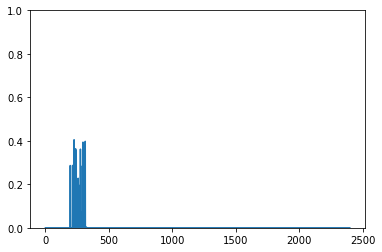

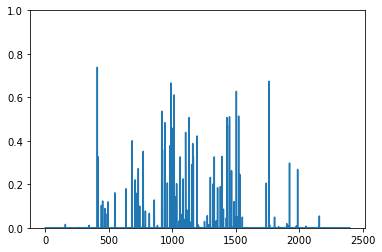

In [9]:
for i, t in enumerate(trigger_list):
    plt.ylim(0, 1)
    plt.plot(trigger_list[i] * mask_list[i])
    plt.show()

In [10]:
trigger_list[0]

array([0.        , 0.63800454, 0.37573922, ..., 0.21604413, 0.9185915 ,
       0.10254145], dtype=float32)